# Animated graphs

## 1. Get data first

In [1]:
import numpy as np
import pandas as pd
from astroquery.utils.tap.core import TapPlus

# CDS TAP service
tap = TapPlus(url="https://tapvizier.cds.unistra.fr/TAPVizieR/tap")

# В TAP таблица обычно называется с префиксом "J/A+A/685/A66/age_cat"
# ADQL требует экранирования имени таблицы двойными кавычками.
table = '\"J/A+A/685/A66/age_cat\"'

query = f"""
SELECT
  Age, e_Age, "[Fe/H]" AS feh, "e_[Fe/H]" AS e_feh
FROM {table}
"""

job = tap.launch_job_async(query)
t = job.get_results()
df = t.to_pandas()

df_age = (df.rename(columns={"Age":"age", "e_Age":"age_err", "feh":"feh", "e_feh":"feh_err"})
            [["age","age_err","feh","feh_err"]])

for c in df_age.columns:
    df_age[c] = pd.to_numeric(df_age[c], errors="coerce")

df_age = df_age.dropna(subset=["age","feh"]).copy()
df_age = df_age[
    (df_age["age"] > 0) & (df_age["age"] < 14) &
    (df_age["feh"] > -2.0) & (df_age["feh"] < 1.0)
].copy()

print("df_age rows:", len(df_age))
df_age.head()

INFO: Query finished. [astroquery.utils.tap.core]
df_age rows: 125443


,age,age_err,feh,feh_err
0,2.40,0.67,-0.12,0.01
1,12.32,2.83,-0.11,0.01
2,6.58,1.37,0.14,0.01
3,4.53,1.00,-0.09,0.01
4,4.74,1.04,0.07,0.01


## 2. Use APOGEE Data to create a graph



matplotlib: 3.10.3
Animation format: gif | FPS=24 | DPI=150
Theme: dark
Project root: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab
Topic root:   /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
Animations:   /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
Animating rows: 125443
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_EN_age_feh_boulet.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_EN_age_feh_boulet.gif exists: True


PosixPath('/Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_EN_age_feh_boulet.gif')

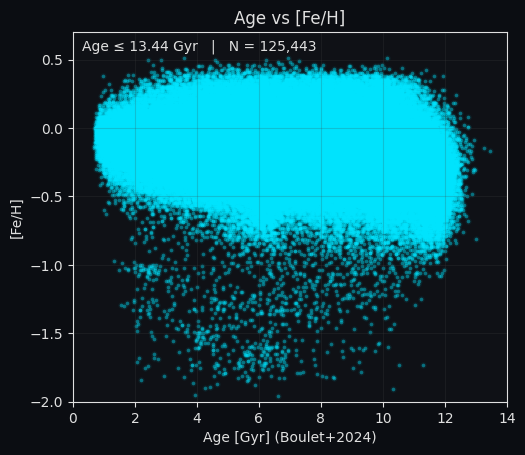

In [2]:
import numpy as np
import matplotlib.animation as animation

from lulab.anim.defaults import apply_theme, THEME, OUT_DIR, FPS, save_animation, print_env
from lulab.anim.plot_helpers import make_fig, set_common_axes, make_corner_text

apply_theme(THEME)
print_env()

# -----------------------------
# 1) Prepare sample (use ALL if <= 200k, else sample)
# -----------------------------
SAMPLE_N = 180_000
samp = df_age.sample(min(len(df_age), SAMPLE_N), random_state=1).copy()
samp = samp.sort_values("age").reset_index(drop=True)

ages = samp["age"].astype(float).to_numpy()
feh  = samp["feh"].astype(float).to_numpy()

print("Animating rows:", len(samp))

# -----------------------------
# 2) Figure styling
# -----------------------------
fig, ax = make_fig(figsize=(5.6, 4.8), grid_alpha=0.22)

set_common_axes(
    ax,
    xlim=(0, 14),
    ylim=(-2.0, 0.7),
    xlabel="Age [Gyr] (Boulet+2024)",
    ylabel="[Fe/H]",
    title="Age vs [Fe/H]"
)

# Bright, high-contrast cyan + glow for dark theme
POINT_COLOR = "#00e5ff"

sc_glow = ax.scatter([], [], s=22, alpha=0.06, c=POINT_COLOR, linewidths=0)
sc      = ax.scatter([], [], s=7,  alpha=0.42, c=POINT_COLOR, linewidths=0)

txt = make_corner_text(ax)
txt.set_text("")

# -----------------------------
# 3) Animation timing
# -----------------------------
DURATION_SEC = 6
N_FRAMES = FPS * DURATION_SEC

age_min, age_max = float(ages.min()), float(ages.max())

def init():
    empty = np.empty((0, 2))
    sc.set_offsets(empty)
    sc_glow.set_offsets(empty)
    txt.set_text("")
    return sc_glow, sc, txt

def update(frame):
    t = frame / (N_FRAMES - 1)
    thr = age_min + t * (age_max - age_min)

    # since ages sorted, searchsorted is fast
    k = np.searchsorted(ages, thr, side="right")
    offsets = np.column_stack([ages[:k], feh[:k]])

    sc.set_offsets(offsets)
    sc_glow.set_offsets(offsets)
    txt.set_text(f"Age ≤ {thr:4.2f} Gyr   |   N = {k:,}")
    return sc_glow, sc, txt

ani = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=N_FRAMES,
    interval=1000 / FPS,
    blit=True
)

# -----------------------------
# 4) Save using your defaults pipeline
# -----------------------------
save_animation(ani, OUT_DIR / "ANIM_002_EN_age_feh_boulet")